In [1]:
%load_ext autoreload


In [2]:
%matplotlib inline
%autoreload 1
import pickle
import numpy as np
from functools import partial
import MDAnalysis

from pathlib import Path

import matplotlib.pyplot as plt
import numpy.typing as npt

import pandas as pd

from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map

%aimport util
from plot_helper import *


Matplotlib Version: 3.6.3


In [3]:
lipids = ["POPC", "DOPC", "POPE", "DOPE", "CDL1", "CDL2", "POPG", "DOPG"]
leaflets = ["upper", "lower"]

queries = {
    "PC": "resname POPC or resname DOPC",
    "PE": "resname POPE or resname DOPE",
    "CDL": "resname CDL1 or resname CDL2",
    "PG": "resname POPG or resname DOPG",
}

po4_neighbor_sel = "name PO4 or name GL0"


In [4]:
# Location to save the final data
curvature_correlation_fd = util.analysis_path / "curvature_correlation.pickle"

if curvature_correlation_fd.exists():
    with open(curvature_correlation_fd, "rb") as handle:
        curvature_correlation_data = pickle.load(handle)
else:
    raise RuntimeError("Curvature correlation cache is missing")


In [ ]:
show_figs = False
curr_fig_path = Path("Figures/curvature_histograms")
curr_fig_path.mkdir(parents=True, exist_ok=True)

for sim in np.concatenate((util.simulations, ["1_vbt"])):

    ahs = curvature_correlation_data[sim]["all"]

    for lipid, query in queries.items():

        if lipid not in curvature_correlation_data[sim]:
            continue
        
        hs = curvature_correlation_data[sim][lipid]

        fig, ax = plt.subplots(1, 1, figsize=(3, 3))  # sharex=True,

        hsn, hs_bins, _ = ax.hist(hs, bins=100, range=[-10, 10], density=True, histtype="step", color="r")

        asn, as_bins, _ = ax.hist(ahs, bins=100, range=[-10, 10], density=True, color="k",
            alpha=0.7,)
        
        print(f"{sim} Overall mean: {np.mean(ahs)}; {lipid} mean {np.mean(hs)}")

        # ax.hist(
        #     np.ravel(mean),
        #     bins=100,
        #     range=[-10, 10],
        #     density=True,
        #     color="k",
        #     alpha=0.7,
        # )

        ax.axvline(0, color="k", linestyle="--", linewidth=1)

        ax.set_xlabel(r"Mean curvature (/nm)")
        ax.set_ylabel(r"Density")

        if sim == "1_vbt":
            ax.set_title(f"1_vbt {lipid}")
        else:
            ax.set_title(f"{util.sim_to_final_index[int(sim)]} {lipid}")
        ax.set_xlim(-10, 10)

        # ax.legend(loc="upper right")

        # # Shrink current axis by 20%
        # box = ax.get_position()
        # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # # Put a legend to the right of the current axis
        # ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

        fig.tight_layout()

        if sim == "1_vbt":
            fig.savefig(curr_fig_path / f"1_vbt_{lipid}.png", format="png")
            fig.savefig(curr_fig_path / f"1_vbt_{lipid}.pdf", format="pdf")
        else:
            fig.savefig(
                curr_fig_path / f"{util.sim_to_final_index[int(sim)]}_{lipid}.png",
                format="png",
            )
            fig.savefig(
                curr_fig_path / f"{util.sim_to_final_index[int(sim)]}_{lipid}.pdf",
                format="pdf",
            )

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


In [ ]:
show_figs = False
curr_fig_path = Path("Figures/curvature_histograms_diff")
curr_fig_path.mkdir(parents=True, exist_ok=True)

for sim in np.concatenate((util.simulations, ["1_vbt"])):
    ahs = curvature_correlation_data[sim]["all"]

    for lipid, query in queries.items():
        if lipid not in curvature_correlation_data[sim]:
            continue

        hs = curvature_correlation_data[sim][lipid]

        fig, ax = plt.subplots(1, 1, figsize=(3, 3))  # sharex=True,

        hsn, hs_bins = np.histogram(hs, bins=100, range=[-10, 10], density=True)
        asn, as_bins = np.histogram(ahs, bins=100, range=[-10, 10], density=True)

        # Lipid specific minus all
        ax.bar(hs_bins[:-1], hsn-asn)

        print(f"{sim} Overall mean: {np.mean(ahs)}; {lipid} mean {np.mean(hs)}")

        # ax.hist(
        #     np.ravel(mean),
        #     bins=100,
        #     range=[-10, 10],
        #     density=True,
        #     color="k",
        #     alpha=0.7,
        # )

        ax.axvline(0, color="k", linestyle="--", linewidth=1)

        ax.set_xlabel(r"Mean curvature (/nm)")
        ax.set_ylabel(r"Density")

        if sim == "1_vbt":
            ax.set_title(f"1_vbt {lipid}")
        else:
            ax.set_title(f"{util.sim_to_final_index[int(sim)]} {lipid}")
        ax.set_xlim(-10, 10)
        ax.set_ylim(-0.02, 0.02)
        # ax.legend(loc="upper right")

        # # Shrink current axis by 20%
        # box = ax.get_position()
        # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # # Put a legend to the right of the current axis
        # ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

        fig.tight_layout()

        if sim == "1_vbt":
            fig.savefig(curr_fig_path / f"1_vbt_{lipid}.png", format="png")
            fig.savefig(curr_fig_path / f"1_vbt_{lipid}.pdf", format="pdf")
        else:
            fig.savefig(
                curr_fig_path / f"{util.sim_to_final_index[int(sim)]}_{lipid}.png",
                format="png",
            )
            fig.savefig(
                curr_fig_path / f"{util.sim_to_final_index[int(sim)]}_{lipid}.pdf",
                format="pdf",
            )

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


In [5]:
show_figs = False
curr_fig_path = Path("Figures/curvature_histograms_diff")
curr_fig_path.mkdir(parents=True, exist_ok=True)


curvature_moment = {}

for sim in np.concatenate((util.simulations, ["1_vbt"])):

    curvature_moment[sim] = {}
    ahs = curvature_correlation_data[sim]["all"]

    for lipid, query in queries.items():
        if lipid not in curvature_correlation_data[sim]:
            continue

        hs = curvature_correlation_data[sim][lipid]

        # fig, ax = plt.subplots(1, 1, figsize=(3, 3))  # sharex=True,

        hsn, hs_bins = np.histogram(hs, bins=100, range=[-10, 10], density=True)
        asn, as_bins = np.histogram(ahs, bins=100, range=[-10, 10], density=True)

        # Lipid specific minus all
        diff = hsn-asn
        bin_centers = ((hs_bins + np.roll(hs_bins, -1))/2)[:-1]

        moment = np.sum(diff*bin_centers)*(bin_centers[1]-bin_centers[0])
        curvature_moment[sim][lipid] = moment
        if sim != "1_vbt":
            print(f"{sim} {util.sim_to_final_index[int(sim)]} moment: {moment}; Overall mean: {np.mean(ahs)}; {lipid} mean {np.mean(hs)}")
        else:
            print(f"{sim} moment: {moment}; Overall mean: {np.mean(ahs)}; {lipid} mean {np.mean(hs)}")
        # ax.axvline(0, color="k", linestyle="--", linewidth=1)

        # ax.set_xlabel(r"Mean curvature (/nm)")
        # ax.set_ylabel(r"Density")

        # if sim == "1_vbt":
        #     ax.set_title(f"1_vbt {lipid}")
        # else:
        #     ax.set_title(f"{util.sim_to_final_index[int(sim)]} {lipid}")
        # ax.set_xlim(-10, 10)
        # ax.set_ylim(-0.02, 0.02)
        # # ax.legend(loc="upper right")

        # # # Shrink current axis by 20%
        # # box = ax.get_position()
        # # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # # # Put a legend to the right of the current axis
        # # ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

        # fig.tight_layout()

        # if sim == "1_vbt":
        #     fig.savefig(curr_fig_path / f"1_vbt_{lipid}.png", format="png")
        #     fig.savefig(curr_fig_path / f"1_vbt_{lipid}.pdf", format="pdf")
        # else:
        #     fig.savefig(
        #         curr_fig_path / f"{util.sim_to_final_index[int(sim)]}_{lipid}.png",
        #         format="png",
        #     )
        #     fig.savefig(
        #         curr_fig_path / f"{util.sim_to_final_index[int(sim)]}_{lipid}.pdf",
        #         format="pdf",
        #     )

        # if show_figs:
        #     plt.show()

        # fig.clear()
        # plt.close(fig)


1 1 moment: -0.17699569727427; Overall mean: 0.17995905549158608; PC mean -0.057694174401475756
1 1 moment: 0.09546234956824576; Overall mean: 0.17995905549158608; PE mean 0.30509666648748607
1 1 moment: 0.6208504241861036; Overall mean: 0.17995905549158608; CDL mean 1.016119576246999
2 2 moment: -0.19624438062592542; Overall mean: 0.17811491365006257; PC mean -0.0845181543626694
2 2 moment: 0.06958197391679266; Overall mean: 0.17811491365006257; PE mean 0.26850146928134094
2 2 moment: 0.6242708655512583; Overall mean: 0.17811491365006257; CDL mean 1.0169557937682079
3 -3 moment: -0.17867638803033828; Overall mean: 0.18080532349843853; PC mean -0.06154949641176149
3 -3 moment: 0.08549510407590336; Overall mean: 0.18080532349843853; PE mean 0.2933497748476879
3 -3 moment: 0.6102934496800048; Overall mean: 0.18080532349843853; CDL mean 1.0124239548514584
4 7 moment: -0.0637952005432681; Overall mean: 0.1784843669584904; PC mean 0.09299173178143054
4 7 moment: 0.1358500391216434; Overall 

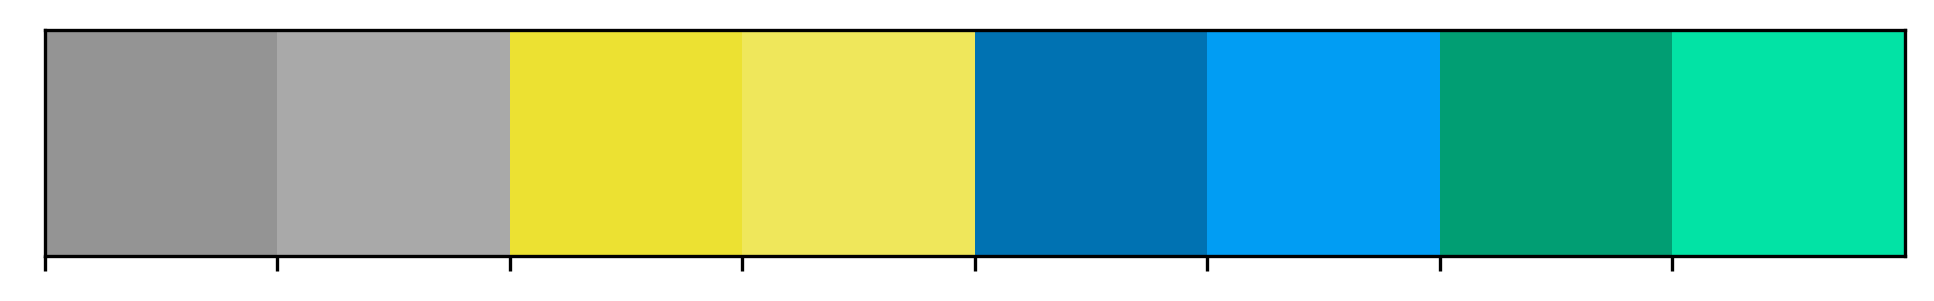

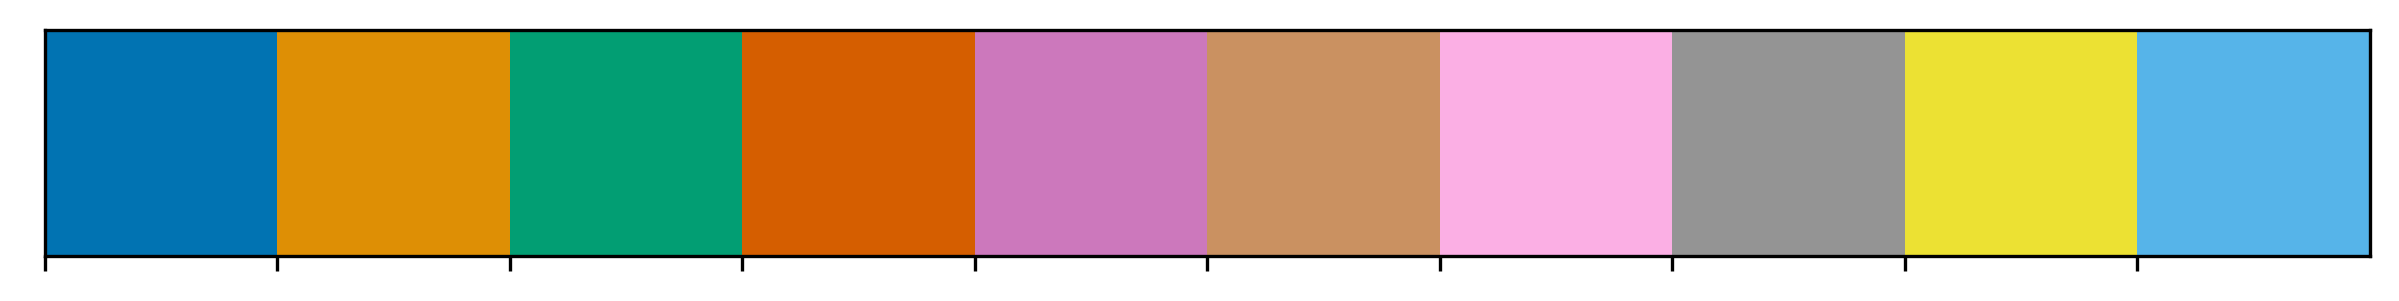

In [6]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

light_factor = 0.8

p = sns.color_palette('colorblind')

palette = [lighten_color(p[i], j) for i, j in [(7, 1),(7, light_factor),(8,1),(8,light_factor),(0,1),(0,light_factor),(2,1),(2,light_factor)]]

sns.palplot(palette)
sns.palplot(p)


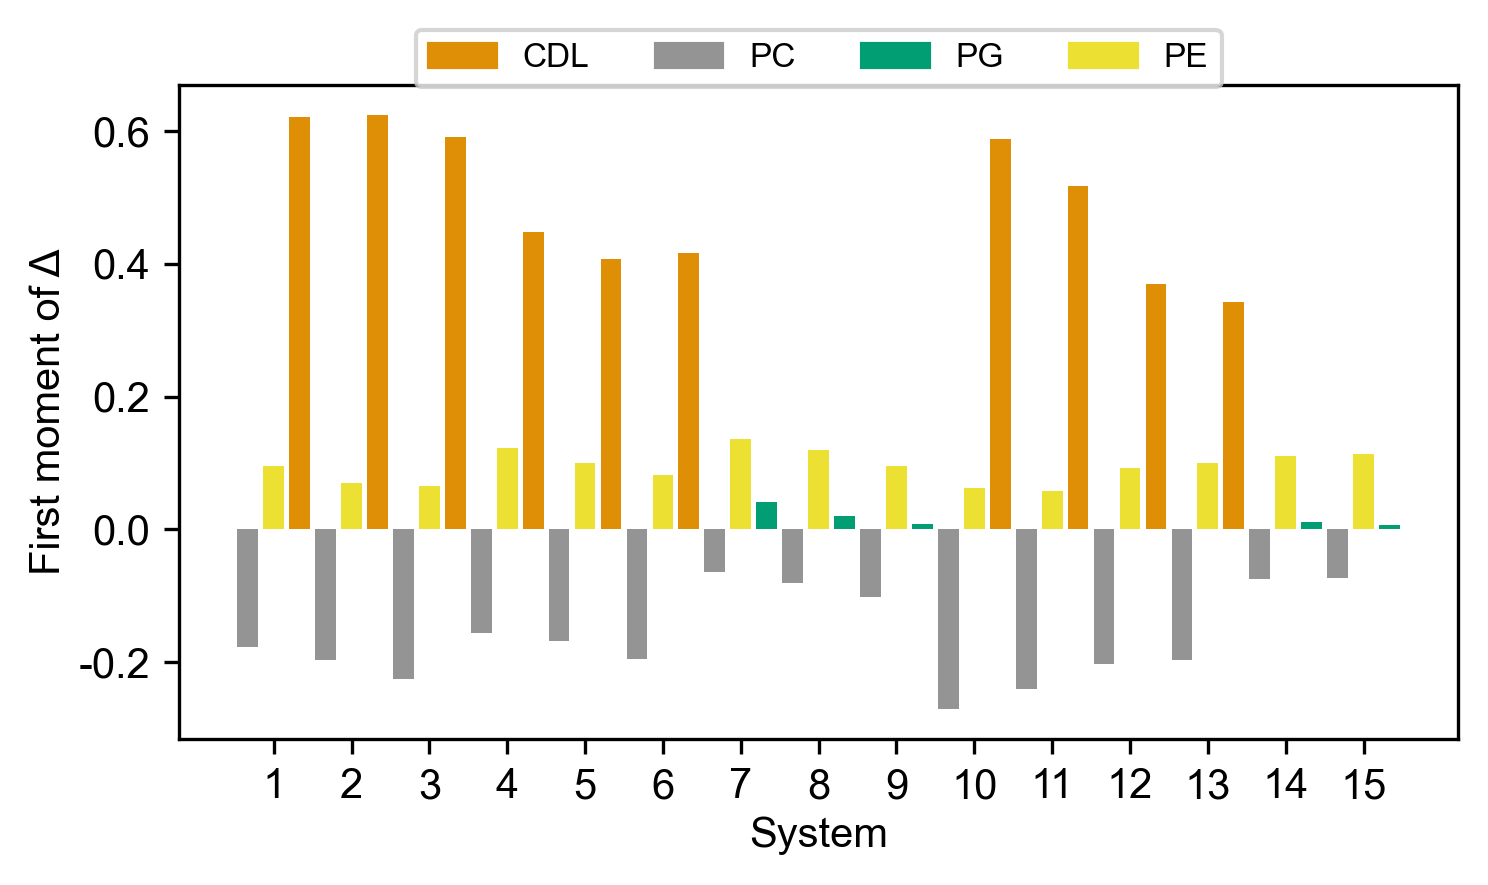

In [26]:
show_figs = True
curr_fig_path = Path("Figures/delta_analysis")
curr_fig_path.mkdir(parents=True, exist_ok=True)

color_index={'CDL': 1, 'PC': 7, 'PG': 2, 'PE': 8}

vals = []
colors = []
for sim in range(1, 16):
    for lipid in queries.keys():
        if lipid not in curvature_moment[str(util.remapping_dict[sim])]:
            continue
        vals.append(curvature_moment[str(util.remapping_dict[sim])][lipid])
        colors.append(p[color_index[lipid]])

# print(vals)
# print(colors)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))  # sharex=True,

ax.bar(range(len(vals)), vals, color=colors)

ax.set_xticks(np.arange(1, len(vals), 3))
ax.set_xticklabels(np.arange(1,16))


patches = [mpatches.Patch(color=p[1], label='CDL'), mpatches.Patch(color=p[7], label='PC'), mpatches.Patch(color=p[2], label='PG'), mpatches.Patch(color=p[8], label='PE')
           ]

box = ax.get_position()
ax.legend(handles=patches, loc="upper center", ncols=4, bbox_to_anchor=(0.5,1.11)) 

ax.set_ylabel("First moment of Δ")
ax.set_xlabel("System")

fig.tight_layout()

fig.savefig(
    curr_fig_path / f"delta1-9.png",
    format="png",
)
fig.savefig(
    curr_fig_path / f"delta1-9.pdf",
    format="pdf",
)

if show_figs:
    plt.show()

fig.clear()
plt.close(fig)
